# 1. Exploring the Dataset

In [2]:
from PIL import Image
import pandas as pd
import numpy as np
train_csv = pd.read_csv('train.csv')
train_csv.head()

,filename,category
0,result_table_img_73171_0_1702481825.jpg,bordered
1,result_table_img_67442_0_1699990843.jpg,bordered
2,result_table_img_50413_2_1692373645.jpg,bordered
3,result_table_img_58780_0_1696352863.jpg,bordered
4,result_table_img_71262_6_1701792733.jpg,bordered


In [3]:
df_x = train_csv['filename'].map('./train/{}'.format)
df_y = train_csv['category']

In [23]:
print(f'Number of dataitems {len(train_csv)}')
print(f'Number of classes {len(train_csv['category'].unique())} ==>  {list(train_csv['category'].unique())}')
print(f'value counts \n {train_csv['category'].value_counts()}')

Number of dataitems 1257
Number of classes 3 ==>  ['bordered', 'borderless', 'row_bordered']
value counts 
 category
bordered        500
borderless      500
row_bordered    257
Name: count, dtype: int64


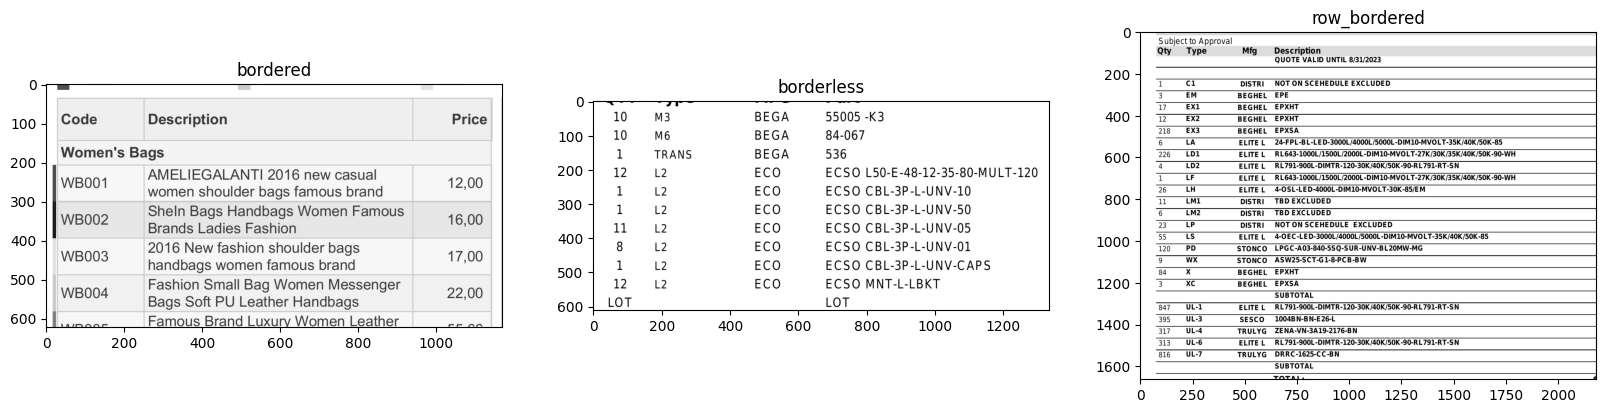

In [25]:
import random
import matplotlib.pyplot as plt

cats = np.unique(train_csv['category'].values)
fig, axes = plt.subplots(1,3, figsize=(20,50))

for i, ax in enumerate(axes.flat):
    
    values = list(train_csv['filename'][train_csv['category'] == cats[i]].values)
    sample = random.choice(values)
    ax.set_title(cats[i])
    ax.imshow(np.asarray(Image.open('./train/'+ sample).convert('RGB')))


# 2. Splitting the dataset using stratified splitting

In [30]:
from sklearn.model_selection import train_test_split
train_df, val_df, train_labels, val_labels = train_test_split(df_x, df_y,
                                                    stratify=df_y, 
                                                    test_size=0.25)

# 3. Creating Datasets, DataLoaders, Transform operations

In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset

In [33]:
label_set = ['bordered','borderless','row_bordered']
id2label = {v: k for v, k in enumerate(label_set)}
label2id = {k: v for v, k in enumerate(label_set)}

class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images.reset_index(drop=True)
        self.labels = labels.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        image = Image.open(image).convert('RGB')
        label = self.labels[idx]
        label = label2id[label]

        if self.transform:
            image = self.transform(image)

        return image, label

In [34]:

transform = transforms.Compose([
    #transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = CustomDataset(train_df, train_labels, transform=transform)
val_dataset = CustomDataset(val_df, val_labels, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# 4. Training a ResNet18 model on Train set

In [36]:
resnet = models.resnet18(pretrained=True)


num_features = resnet.fc.in_features
resnet.fc = nn.Sequential(
    nn.Linear(num_features, 1024),
    nn.ReLU(),
    nn.Linear(1024, 3)
)

d:\Quixy\Parspec\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Quixy\Parspec\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_save_path = './resnet.pth'

resnet = resnet.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=0.00005)

num_epochs = 10
best_val_loss = float('inf')
for epoch in range(num_epochs):
    resnet.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = resnet(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")

    resnet.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = resnet(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    print(f"Validation Loss: {val_loss}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': resnet.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': running_loss / len(train_loader),
            'val_loss': val_loss
        }, model_save_path)
        print(f"Model saved at epoch {epoch+1} with validation loss {val_loss}")

print("Training complete. Best model saved at", model_save_path)


Epoch 1, Loss: 0.5754882509509722
Validation Loss: 0.28774399757385255
Model saved at epoch 1 with validation loss 0.28774399757385255
Epoch 2, Loss: 0.13831734719375768
Validation Loss: 0.09077035412192344
Model saved at epoch 2 with validation loss 0.09077035412192344
Epoch 3, Loss: 0.06799903564775983
Validation Loss: 0.06508061587810517
Model saved at epoch 3 with validation loss 0.06508061587810517
Epoch 4, Loss: 0.036966331272075575
Validation Loss: 0.06537967072799802
Epoch 5, Loss: 0.02380864517763257
Validation Loss: 0.06343578775413335
Model saved at epoch 5 with validation loss 0.06343578775413335
Epoch 6, Loss: 0.008500512790245314
Validation Loss: 0.04829033499117941
Model saved at epoch 6 with validation loss 0.04829033499117941
Epoch 7, Loss: 0.004765734992300471
Validation Loss: 0.057072288217023016
Epoch 8, Loss: 0.0031614069788095853
Validation Loss: 0.051436995971016586
Epoch 9, Loss: 0.0027012854639906435
Validation Loss: 0.05055035291006789
Epoch 10, Loss: 0.004715

# 5. Loading the model and inferencing

## 5.1 Inferencing

In [3]:
import torch
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
import torch.nn.functional as F
import torch.nn as nn

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(pretrained=False)
num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_features, 1024),
    nn.ReLU(),
    nn.Linear(1024, 3)
)

model = model.to(device)

checkpoint = torch.load('./resnet.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

label_set = ['bordered','borderless','row_bordered']
id2label = {v: k for v, k in enumerate(label_set)}
label2id = {k: v for v, k in enumerate(label_set)}

def predict(image_path):
   
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0)  
    image = image.to(device)
    with torch.no_grad():
        outputs = model(image)
        probabilities = F.softmax(outputs, dim=1)
        _, predicted = torch.max(probabilities, 1)

    return predicted.item(), probabilities

Predicted class: bordered 
Probability: 0.9990683197975159


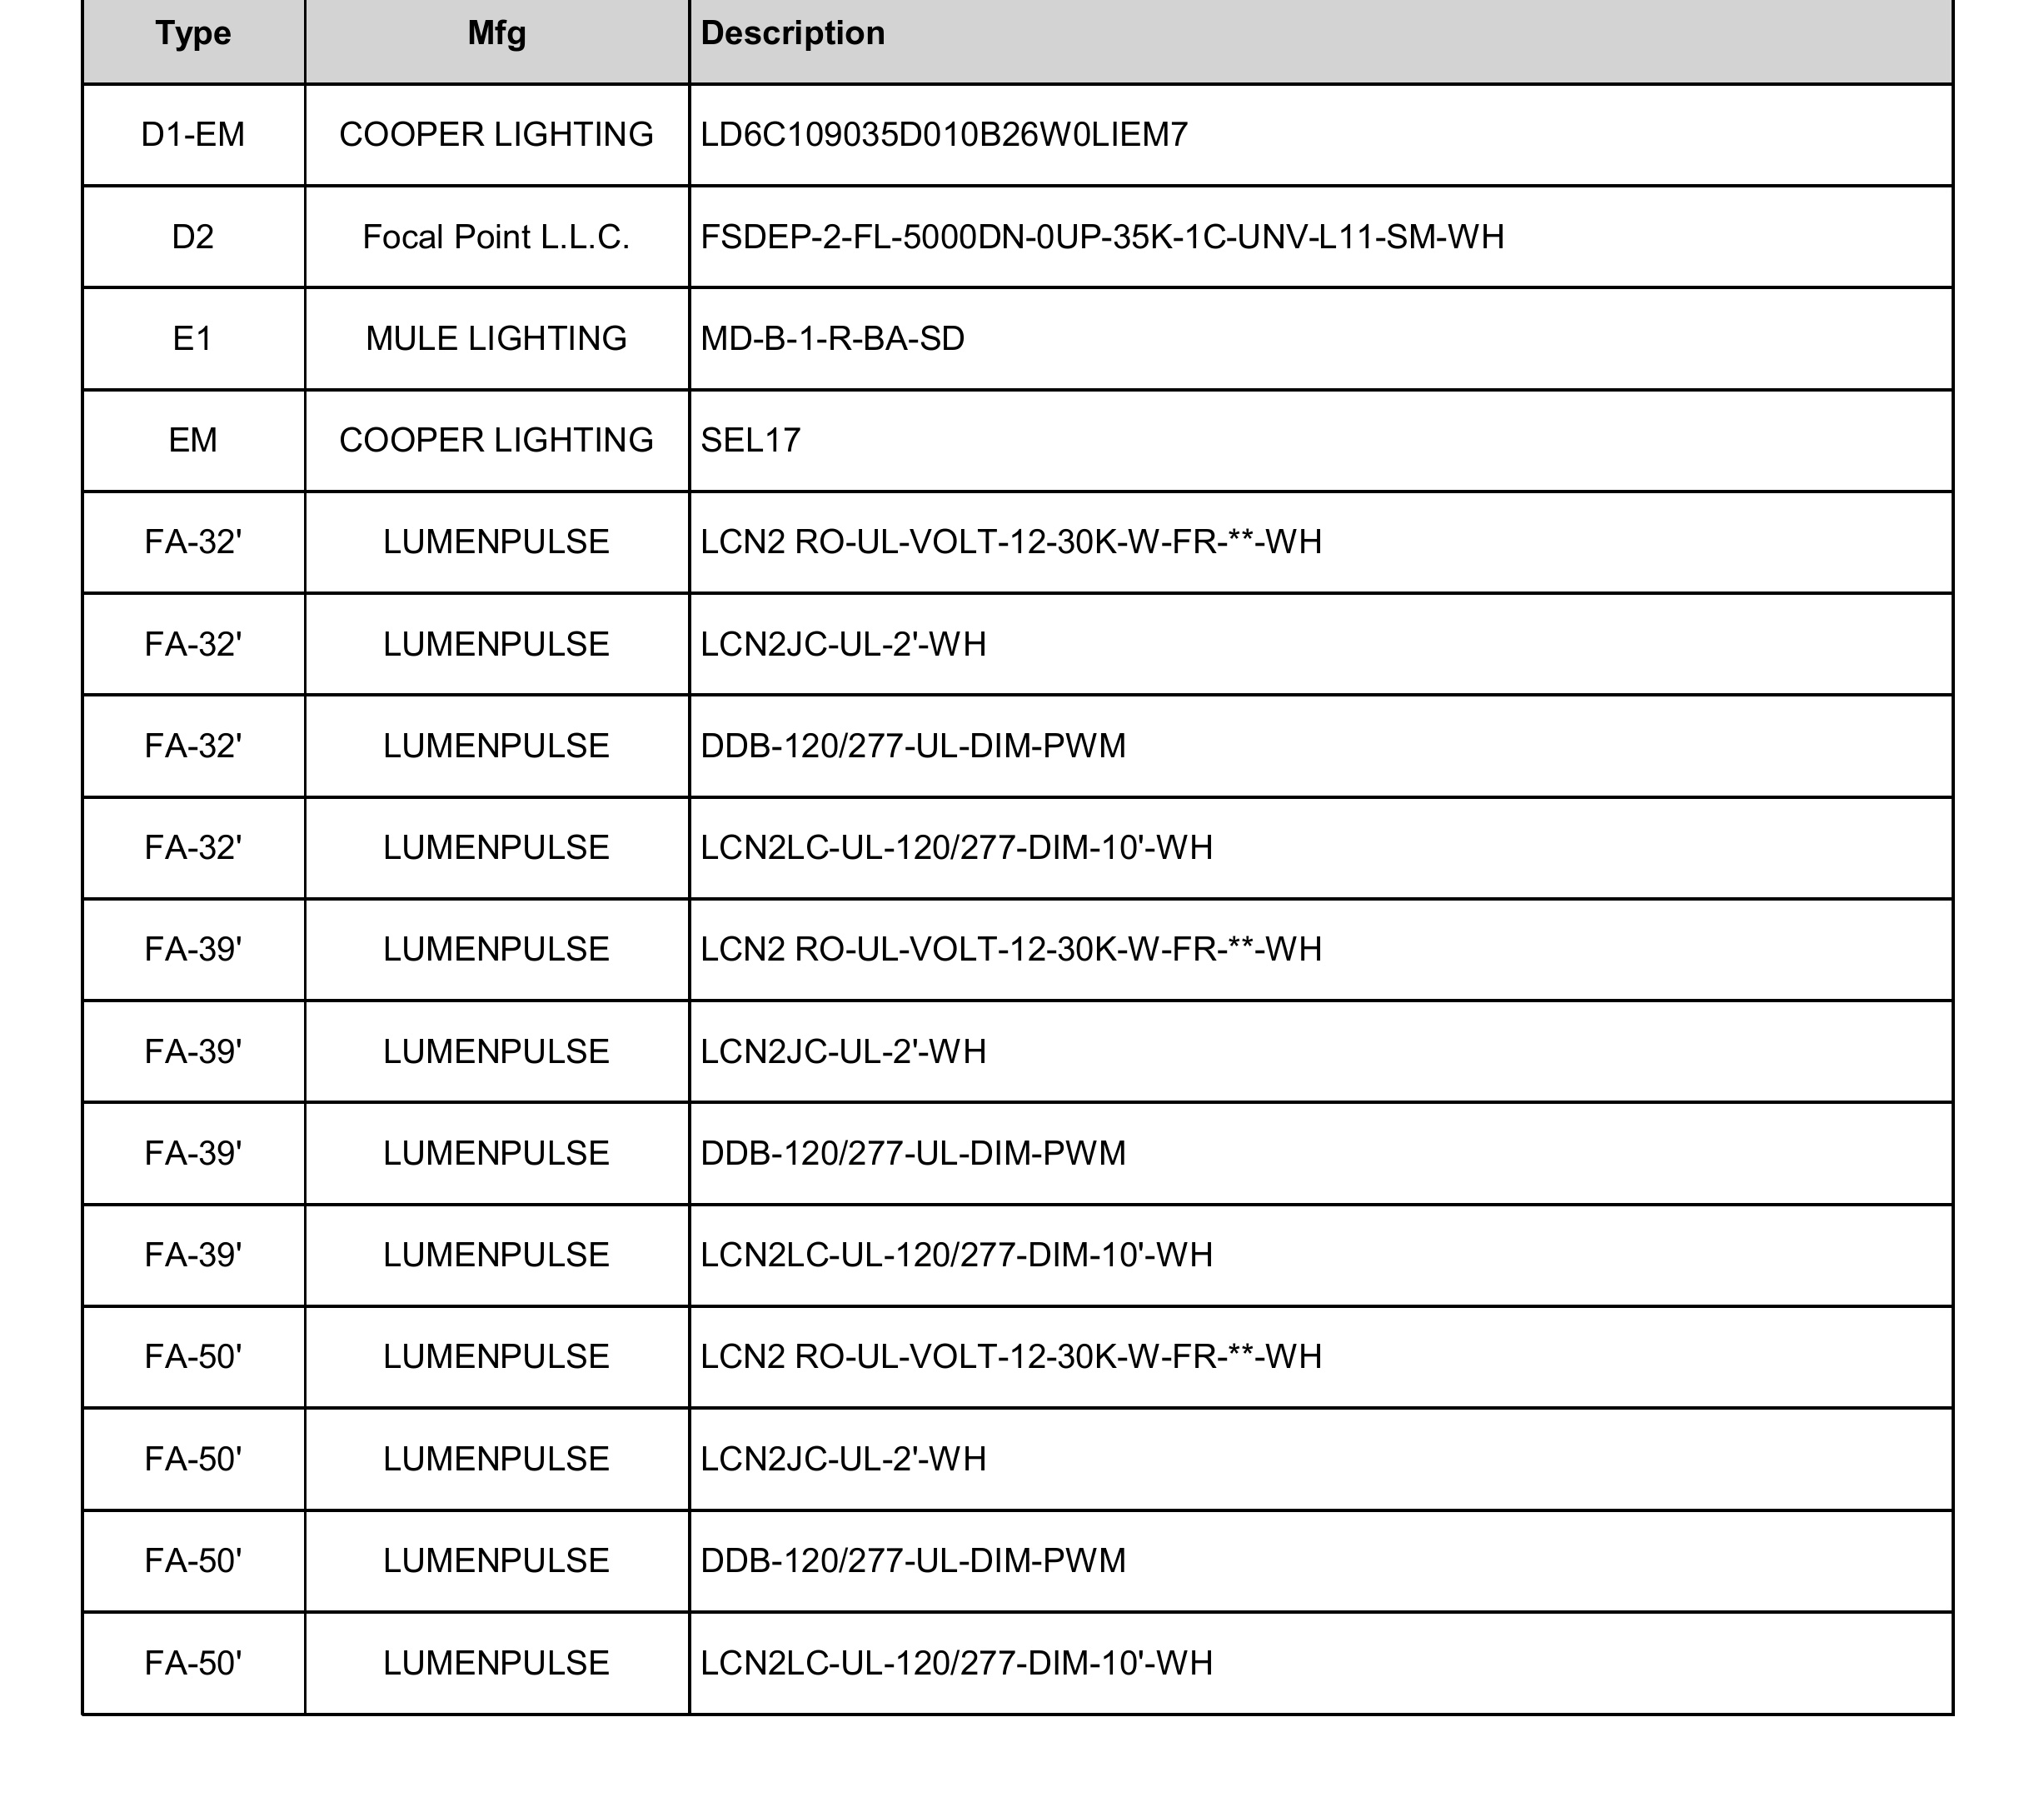

In [6]:
image_path = r'test/result_table_img_86070_0_1707342385.jpg'

predicted_class, probs = predict(image_path)
print(f"Predicted class: {label_set[predicted_class]} \nProbability: {probs[0][predicted_class]}")
Image.open(image_path)

## 5.2 Inferencing on Test data

In [7]:
import pandas as pd
test_csv = pd.read_csv('./test.csv')
test_csv.head()

,filename,category
0,result_table_img_92832_0_1713907027.jpg,bordered
1,result_table_img_49176_0_1691792667.jpg,bordered
2,result_table_img_87167_0_1707768847.jpg,bordered
3,result_table_img_64586_1_1698852744.jpg,bordered
4,result_table_img_88112_6_1708002320.jpg,bordered


In [17]:
print(f'Number of dataitems {len(test_csv)}')
print(f'Number of classes {len(test_csv['category'].unique())} ==>  {list(test_csv['category'].unique())}')
print(f'value counts \n {test_csv['category'].value_counts()}')

Number of dataitems 300
Number of classes 3 ==>  ['bordered', 'borderless', 'row_bordered']
value counts 
 category
bordered        100
borderless      100
row_bordered    100
Name: count, dtype: int64


In [14]:
filenames = ['./test/'+ filename for filename in test_csv.filename.values]
test_labels = [label2id[cat] for cat in test_csv.category.values]

In [15]:
from tqdm import tqdm

pred_probs, preds = [], []
for image_path in tqdm(filenames):
    predicted_class, prob = predict(image_path)
    pred_probs.append(prob[0][predicted_class])
    preds.append(predicted_class)

100%|██████████| 300/300 [00:32<00:00,  9.23it/s]


Accuracy Score----- 0.9733333333333334
F1 Score----- 0.9732795538815947
Classification report
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       100
           1       0.98      0.99      0.99       100
           2       0.98      0.95      0.96       100

    accuracy                           0.97       300
   macro avg       0.97      0.97      0.97       300
weighted avg       0.97      0.97      0.97       300

Test Confusion matrices


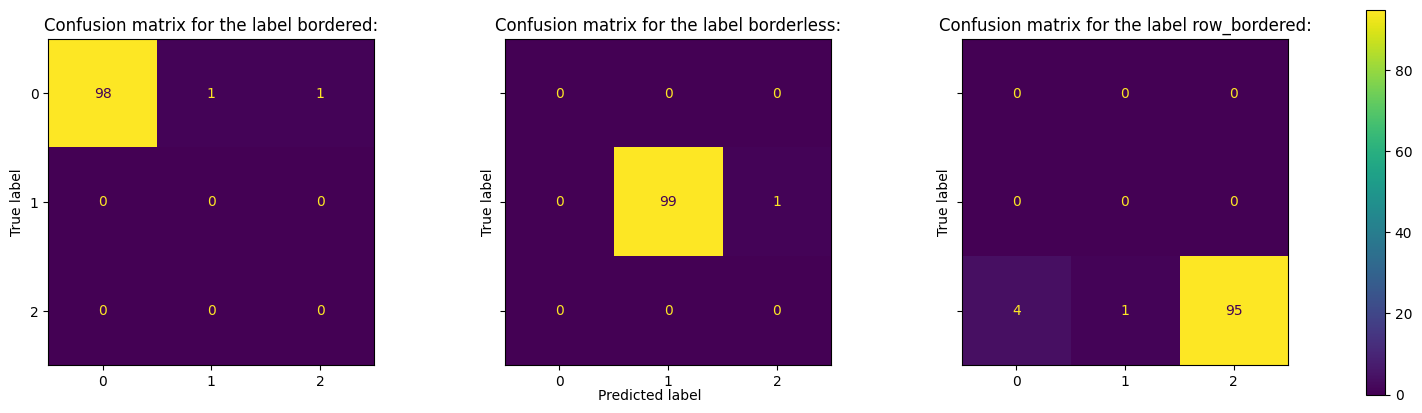

In [43]:
import numpy as np
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay, classification_report
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt

def generate_confusion_matrix(y_true,y_pred):
    cmap = 'viridis'
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    labels = ['bordered','borderless','row_bordered']
    fig, axs = plt.subplots(1, 3, figsize=(20, 5), sharey='row')

    conf_mat_dict={}

    for i in range(len(labels)):
        y_true_label = y_true[i*100:(i+1)*100]
        y_pred_label = y_pred[i*100:(i+1)*100]
        conf_mat_dict[labels[i]] = [y_true_label, y_pred_label]


    for i,(label, matrix) in enumerate(conf_mat_dict.items()):

        cf_matrix = confusion_matrix(matrix[0],matrix[1],labels=[0,1, 2])
        disp = ConfusionMatrixDisplay(cf_matrix)
        disp.plot(ax=axs[i],cmap = cmap)
        disp.ax_.set_title("Confusion matrix for the label {}:".format(label))
        disp.im_.colorbar.remove()
        disp.ax_.set_xlabel('')
    fig.text(0.4, 0.1, 'Predicted label', ha='left')
    plt.subplots_adjust(wspace=0.40, hspace=0.1)

    fig.colorbar(disp.im_, ax=axs)
    plt.show()

print("Accuracy Score-----", accuracy_score(test_labels, preds))
print("F1 Score-----",f1_score(test_labels, preds, average= 'weighted'))
print('Classification report')
print(classification_report(test_labels, preds, labels= [0, 1, 2]))
print('Test Confusion matrices')
generate_confusion_matrix(test_labels, preds)